# CRLB comparison example
The CRLB comparison process of the FD-DeepLoc includes the following steps:
1. Set the path for the trained network model
2. Load the network and plot the training process
3. Set necessary parameters
4. Check the CRLB of a local PSF at given position
5. Compare network's performance with local single-emitter CRLB

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

%matplotlib notebook
sns.set_style("white")
sys.setrecursionlimit(10000)

from fd_deeploc_core import *
from local_utils import *

## 1. Set the path for the trained network model.

In [2]:
fd_deeploc_path = "./demo_datasets/demo1_FD_astig_simu_comparison_and_CRLBtest/demo1_FD-DeepLoc.pkl"
decode_path = "./demo_datasets/demo1_FD_astig_simu_comparison_and_CRLBtest/demo1_DECODE.pkl"
image_path = "./demo_datasets/demo1_FD_astig_simu_comparison_and_CRLBtest/sim_data_normal_aberration_medium_SNR.tif"

fd_deeploc_save_path = './'+os.path.split(fd_deeploc_path)[-1].split('.')[0]+'_'+os.path.split(image_path)[-1].split('.')[0]+'.csv'
print(fd_deeploc_save_path)

decode_save_path = './'+os.path.split(decode_path)[-1].split('.')[0]+'_'+os.path.split(image_path)[-1].split('.')[0]+'.csv'
print(decode_save_path)

./demo1_FD-DeepLoc_sim_data_normal_aberration_medium_SNR.csv
./demo1_DECODE_sim_data_normal_aberration_medium_SNR.csv


## 2. Load the network and plot the training process.


------------------------------------------FD-DeepLoc model-------------------------------------------


<IPython.core.display.Javascript object>


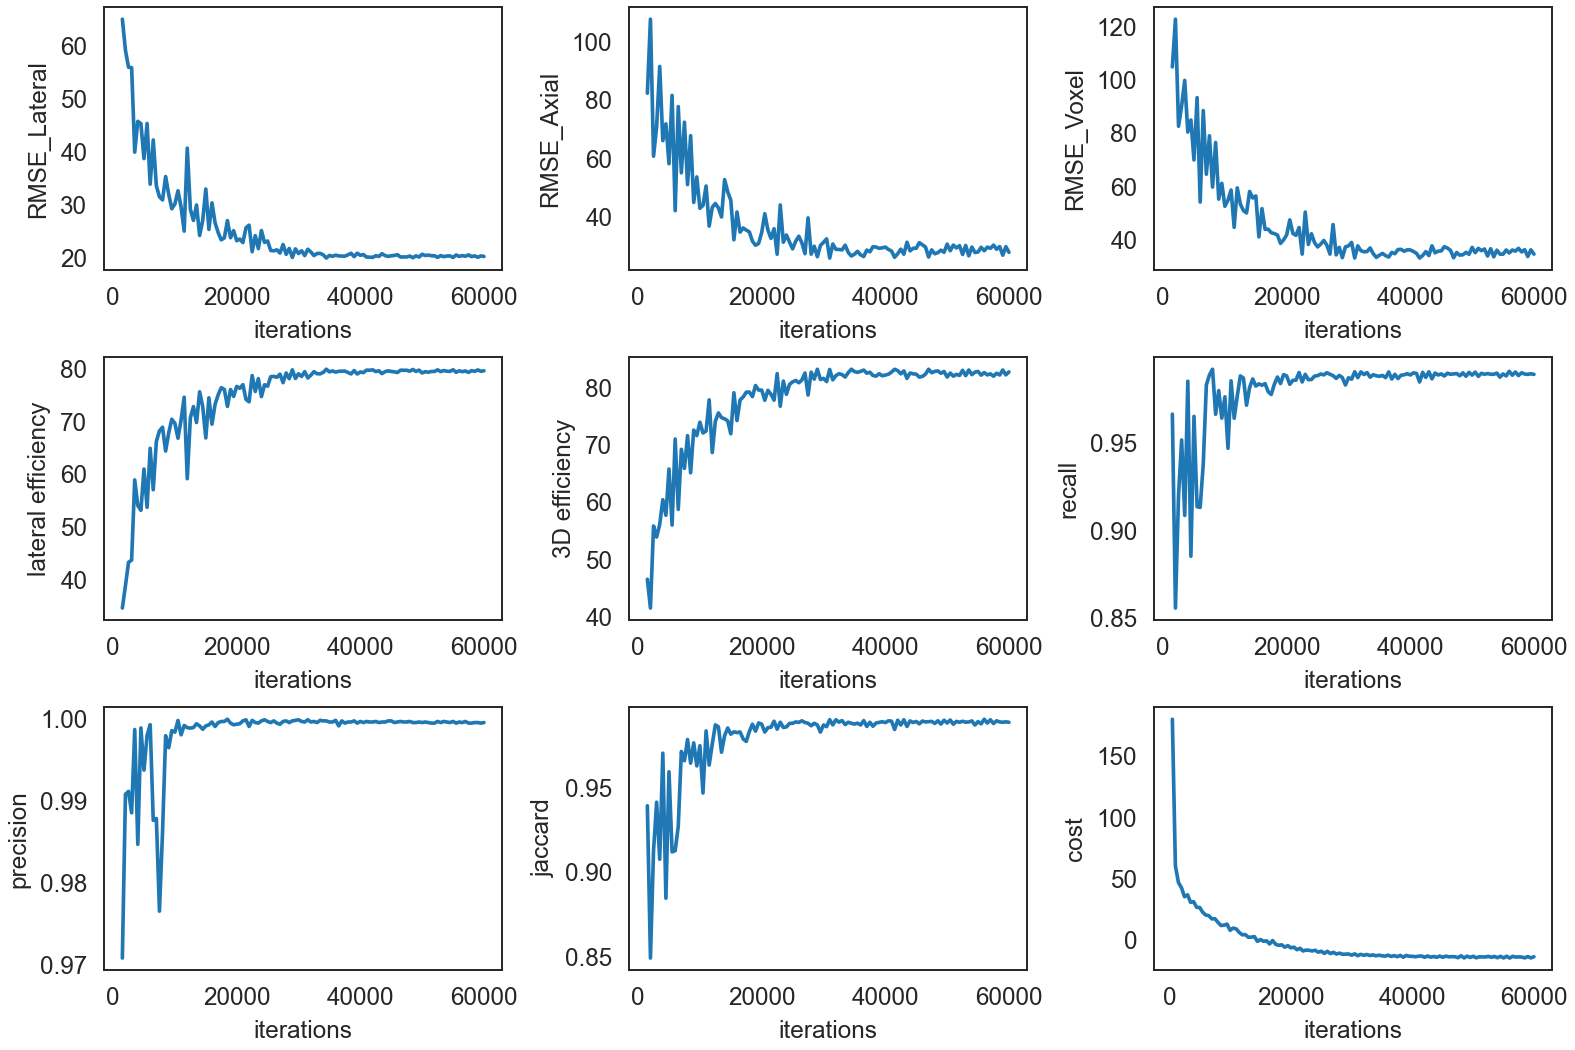

------------------------------------------DECODE model-------------------------------------------


<IPython.core.display.Javascript object>


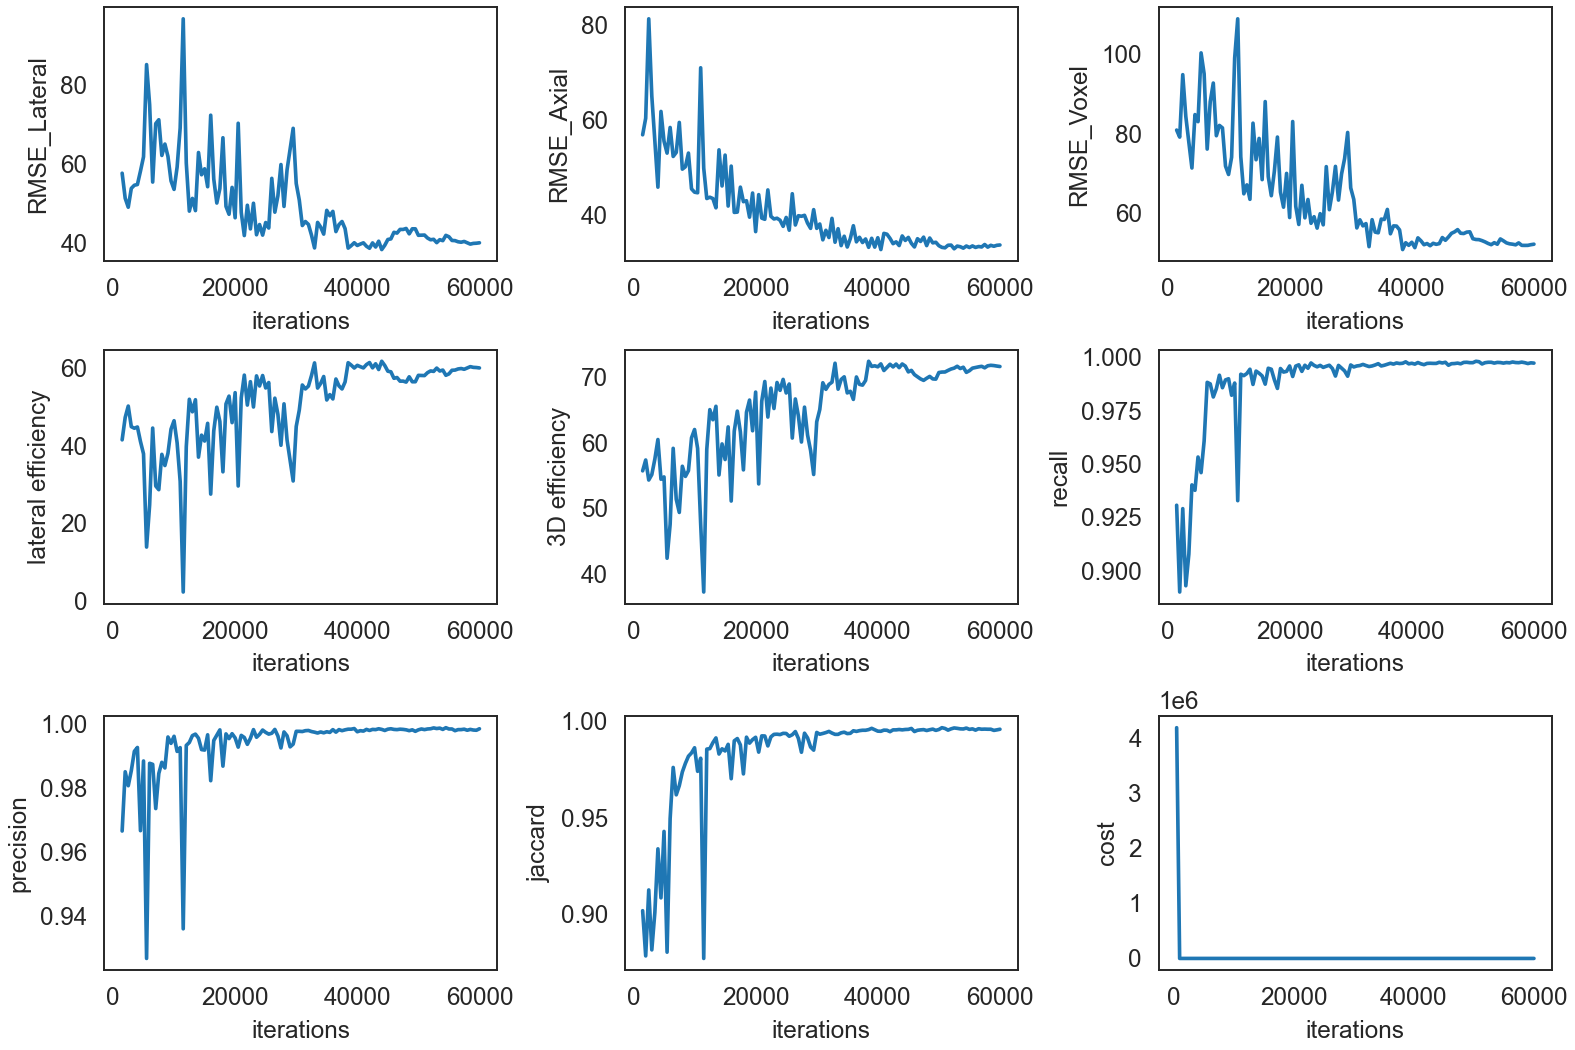

In [3]:
# load the completely trained FD_DECODE model to test or predict
with open(fd_deeploc_path, 'rb') as f:
    fd_deeploc_model = pickle.load(f)
with open(decode_path, 'rb') as f:
    decode_model = pickle.load(f)

# plot performance during the training
print('------------------------------------------FD-DeepLoc model-------------------------------------------')
plot_train_record(fd_deeploc_model)
print('------------------------------------------DECODE model-------------------------------------------')
plot_train_record(decode_model)

## 3. Set necessary parameters.
* `mol_photons` is the average number of signal photons used in training.
* `bg_photons` is the average number of background photons used in training.
* `test_pos` is the global position of the PSF whose CRLB will be computed.
* `Nmol` is the number of sampled z positions, which are uniformly distributed in the training z range.
* `test_num` is the number of simulated random PSFs at each sampled z position for RMSE evaluation, the total number of test set is $testnum*Nmol$.The xy positions for each single emitter are random in the center two pixel, the z position is random in a step range $(zrange/(Nmol-1))$ around each z position.

In [4]:
# set necessary parameters
print(fd_deeploc_model.dat_generator.psf_pars['aber_map'].shape)
bg_photons = (fd_deeploc_model.dat_generator.simulation_pars['backg'] - fd_deeploc_model.dat_generator.simulation_pars['baseline']) \
                     / fd_deeploc_model.dat_generator.simulation_pars['em_gain'] * fd_deeploc_model.dat_generator.simulation_pars['e_per_adu'] \
                     / fd_deeploc_model.dat_generator.simulation_pars['qe']
mol_photons = (fd_deeploc_model.dat_generator.simulation_pars['min_ph'] + 1) / 2 * fd_deeploc_model.dat_generator.psf_pars['ph_scale']
print('{}{}{}{}{}'.format('The average signal/background used for training are: ', int(mol_photons), '/', int(bg_photons), ' photons'))
aber_w = fd_deeploc_model.dat_generator.psf_pars['aber_map'].shape[1]
aber_h = fd_deeploc_model.dat_generator.psf_pars['aber_map'].shape[0]
test_pos_list = [[int(aber_w*0.5), int(aber_h*0.5)],
                 [int(aber_w*0.95), int(aber_h*0.95)]]
print(test_pos_list)

Nmol = 25
test_num = 2000

(2048, 2048, 23)
The average signal/background used for training are: 4998/49 photons
[[1024, 1024], [1945, 1945]]


## 4. Check the CRLB of a local PSF at given position.
* `model` is the FD-DeepLoc model.
* `test_pos` is the global position where the PSF CRLB will be computed and checked.
* `test_photons` is the number of signal photons used to compute CRLB.
* `test_bg` is the number of background photons used to compute CRLB.
* `Nmol` is the number of sampled z positions, which are uniformly distributed in the training z range.

------------------------------------------FD-DeepLoc model-------------------------------------------


D:\Softwares\anaconda\envs\fd_deeploc\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


look PSF model at this position [1024, 1024]


<IPython.core.display.Javascript object>


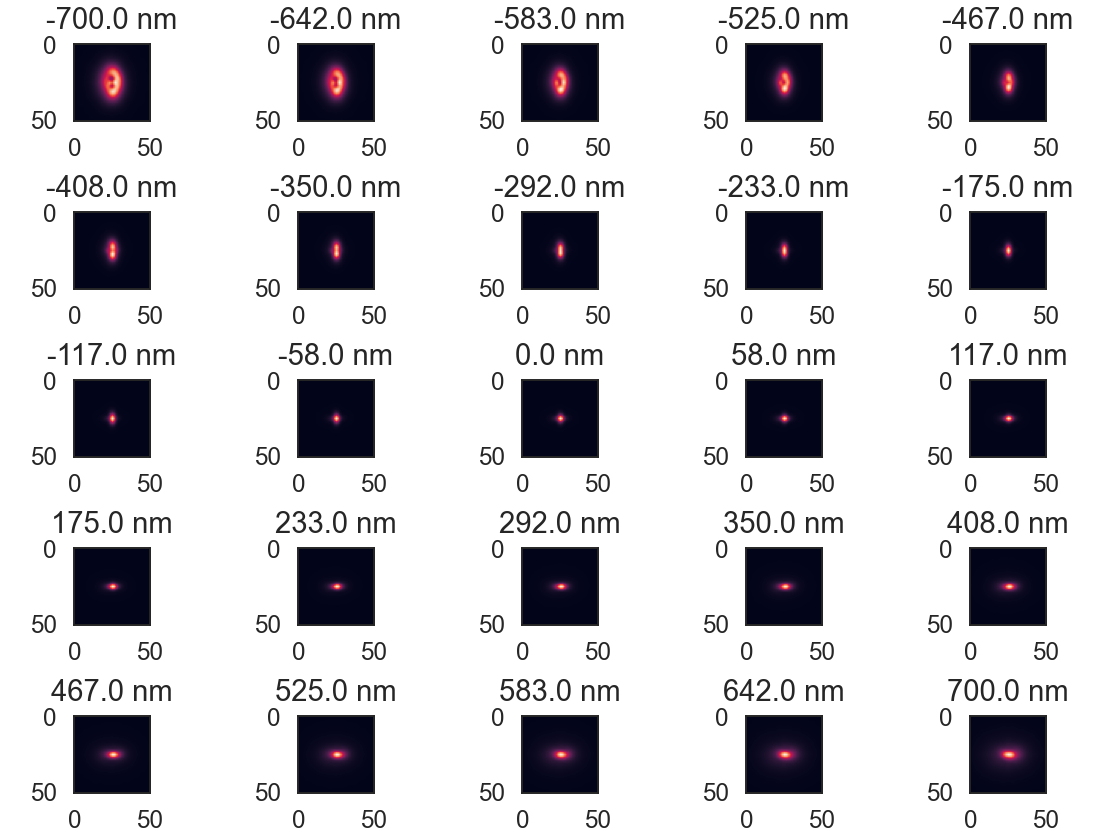

average 3D CRLB is: 863.491796875


<IPython.core.display.Javascript object>


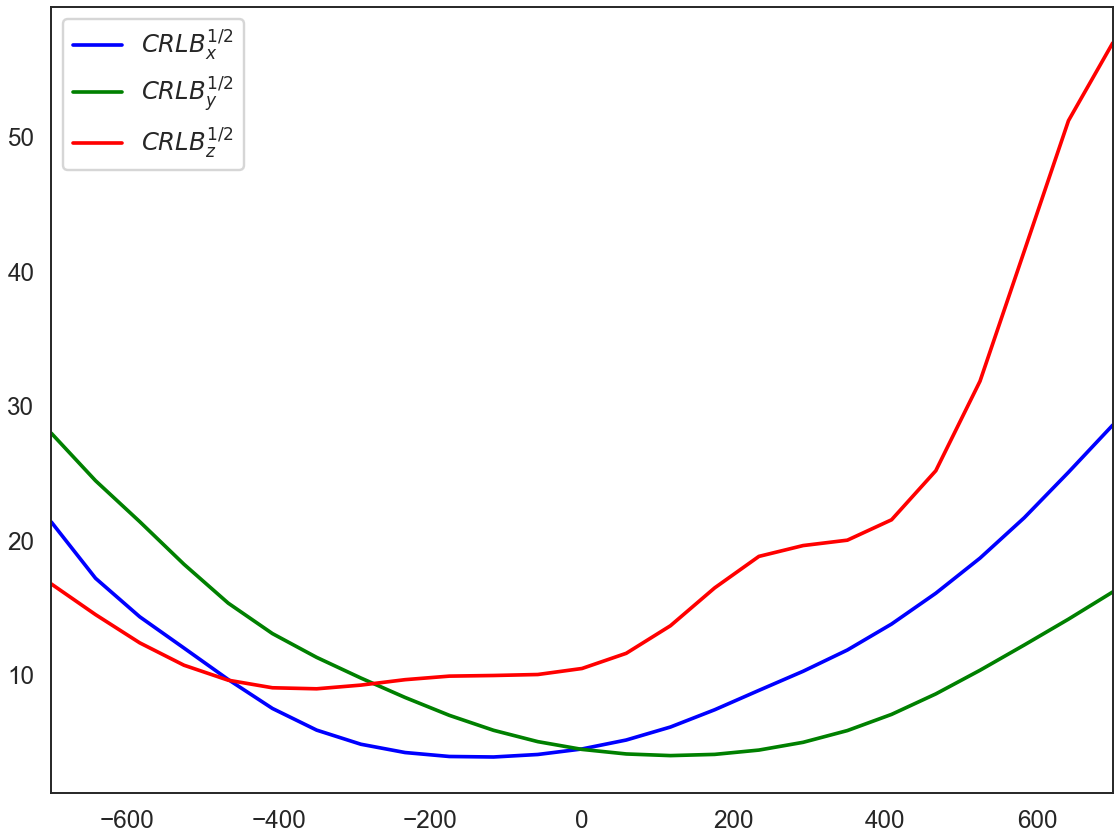

------------------------------------------DECODE model-------------------------------------------
look PSF model at this position [1024, 1024]


<IPython.core.display.Javascript object>


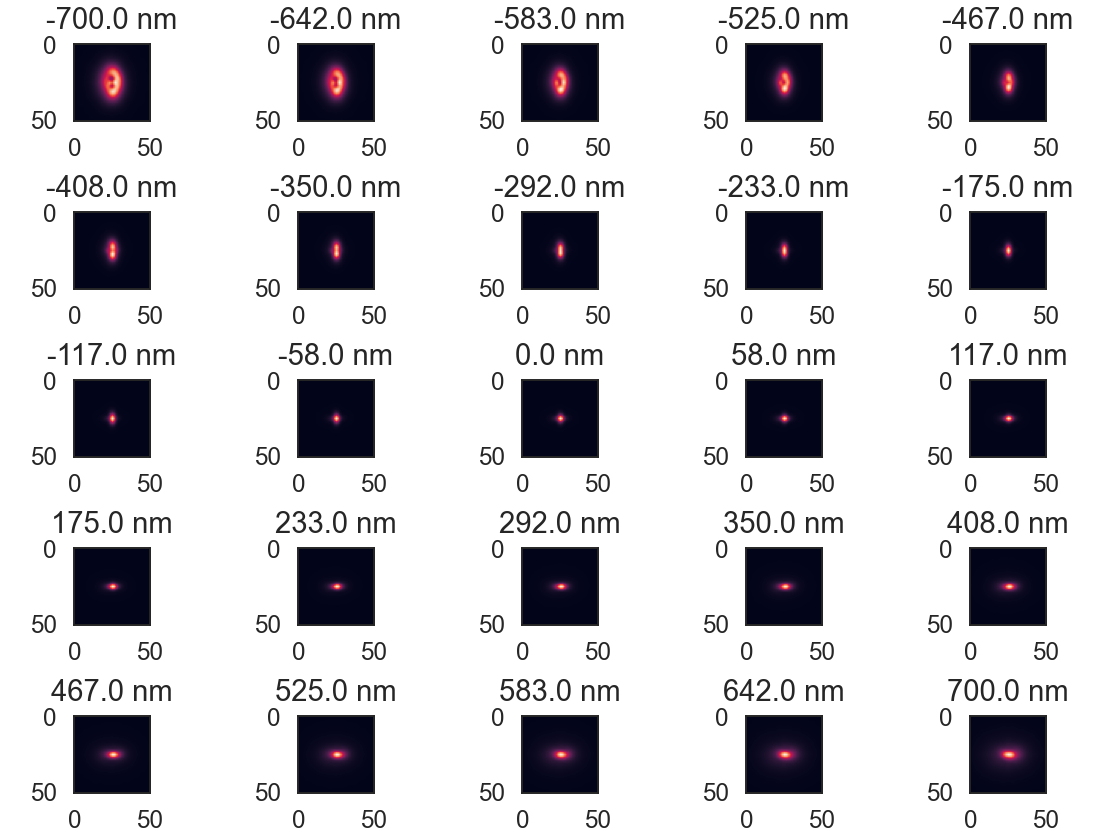

average 3D CRLB is: 863.491796875


<IPython.core.display.Javascript object>


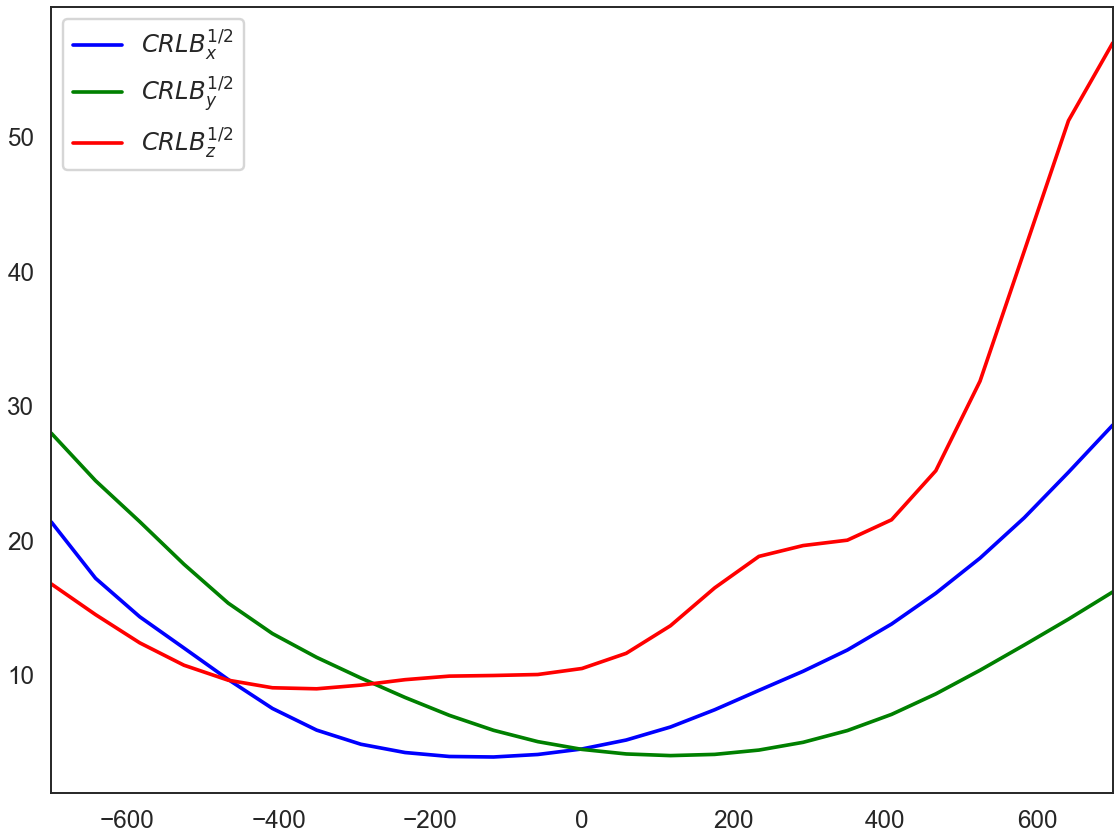

In [5]:
print('------------------------------------------FD-DeepLoc model-------------------------------------------')
check_local_CRLB(model=fd_deeploc_model, test_pos=test_pos_list[0], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol)
print('------------------------------------------DECODE model-------------------------------------------')
check_local_CRLB(model=decode_model, test_pos=test_pos_list[0], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol)

## 5. Compare network's performance with local single-emitter CRLB.
* `use_train_cam`: If true, the single-emitter test set will be simulated using the camera noise of training (e.g., qe, readout noise, analog-to-digital conversion factor). Otherwise only poisson noise will be added.
* `test_num` is the number of simulated random PSFs at each sampled z position for RMSE evaluation, the total number of test set is $testnum*Nmol$.The xy positions for each single emitter are random in the center two pixel, the z position is random in a step range $(zrange/(Nmol-1))$ around each z position.
* The remaining is the same as above.

------------------------------------------FD-DeepLoc model-------------------------------------------
compare with PSF CRLB at this position [1024, 1024]
average 3D CRLB is: 863.491796875
simulating single-emitter images for CRLB test
simulated 50000/50000 images

example single-emitter data for CRLB test


<IPython.core.display.Javascript object>


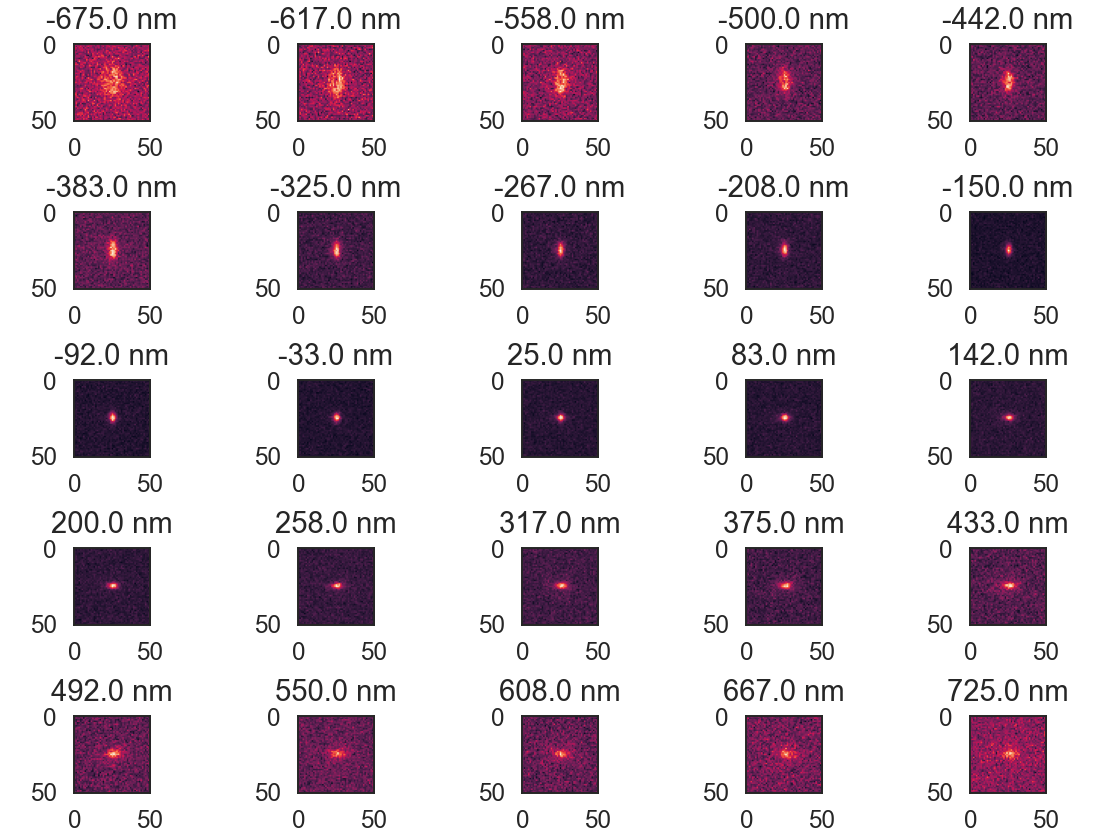

start inferring
field_xy: [ 998. 1049.  998. 1049.] , use_coordconv: True , aber_map_size: (2048, 2048, 23)


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:56<00:00, 107.54it/s]


start computing evaluation metrics

evaluation on 50000 images, contain ground truth: 50000, preds:49688
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 50000 ,preds: 49688
Recall: 0.994
Precision: 1.000
Jaccard: 99.376
RMSE_lat: 19.642
RMSE_ax: 24.577
RMSE_vol: 31.462
Jaccard/RMSE: 5.059
Eff_lat: 80.349
Eff_ax: 87.696
Eff_3d: 84.022
FN: 312.0 FP: 0.0
plot the RMSE of network prediction vs CRLB


<IPython.core.display.Javascript object>


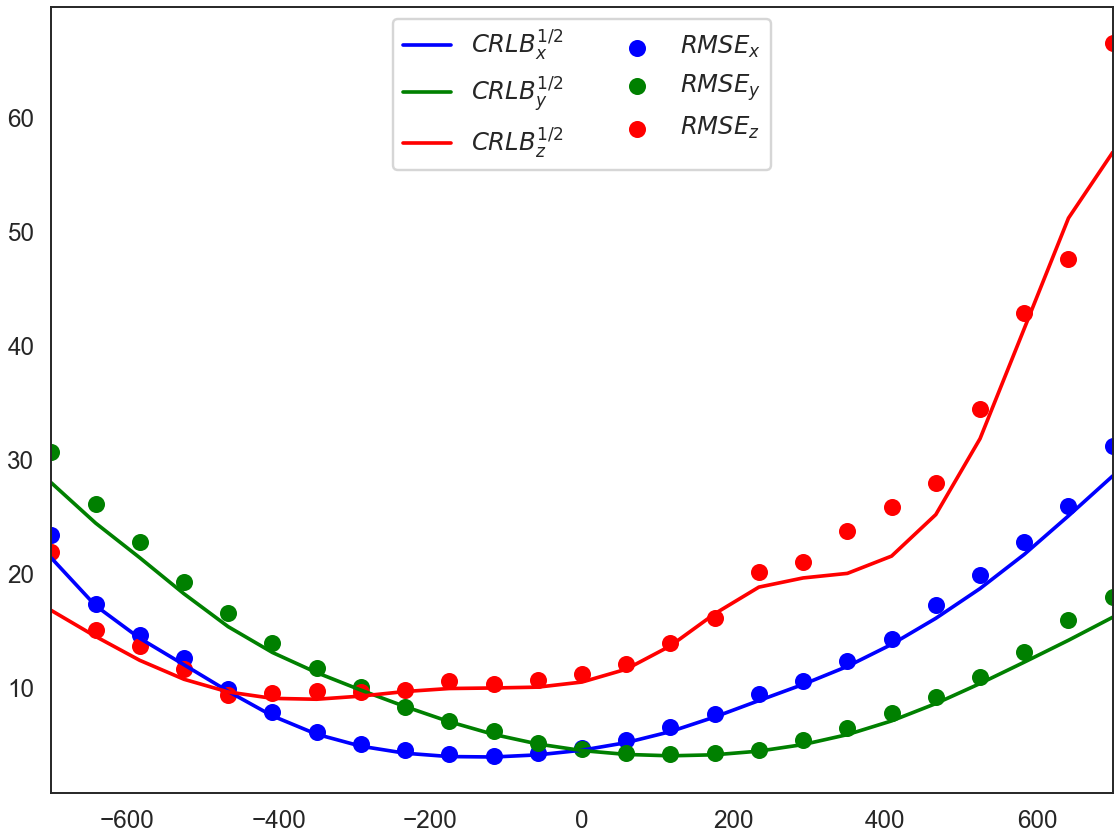

------------------------------------------DECODE model-------------------------------------------
compare with PSF CRLB at this position [1024, 1024]
average 3D CRLB is: 863.491796875
simulating single-emitter images for CRLB test
simulated 50000/50000 images

example single-emitter data for CRLB test


<IPython.core.display.Javascript object>


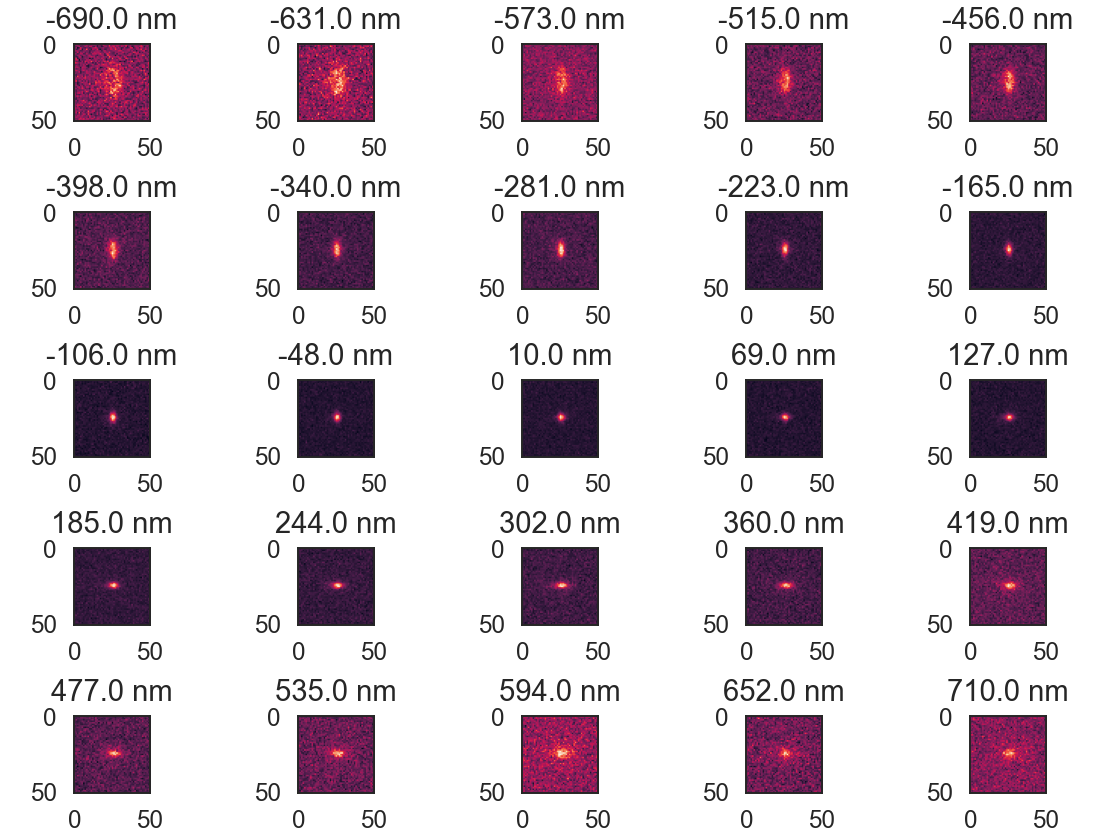

start inferring
field_xy: [ 998. 1049.  998. 1049.] , use_coordconv: False , aber_map_size: (2048, 2048, 23)


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:15<00:00, 165.68it/s]


start computing evaluation metrics

evaluation on 50000 images, contain ground truth: 50000, preds:49981
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 50000 ,preds: 49981
Recall: 0.999
Precision: 1.000
Jaccard: 99.894
RMSE_lat: 42.298
RMSE_ax: 27.902
RMSE_vol: 50.672
Jaccard/RMSE: 2.362
Eff_lat: 57.702
Eff_ax: 86.049
Eff_3d: 71.875
FN: 36.0 FP: 17.0
plot the RMSE of network prediction vs CRLB


<IPython.core.display.Javascript object>


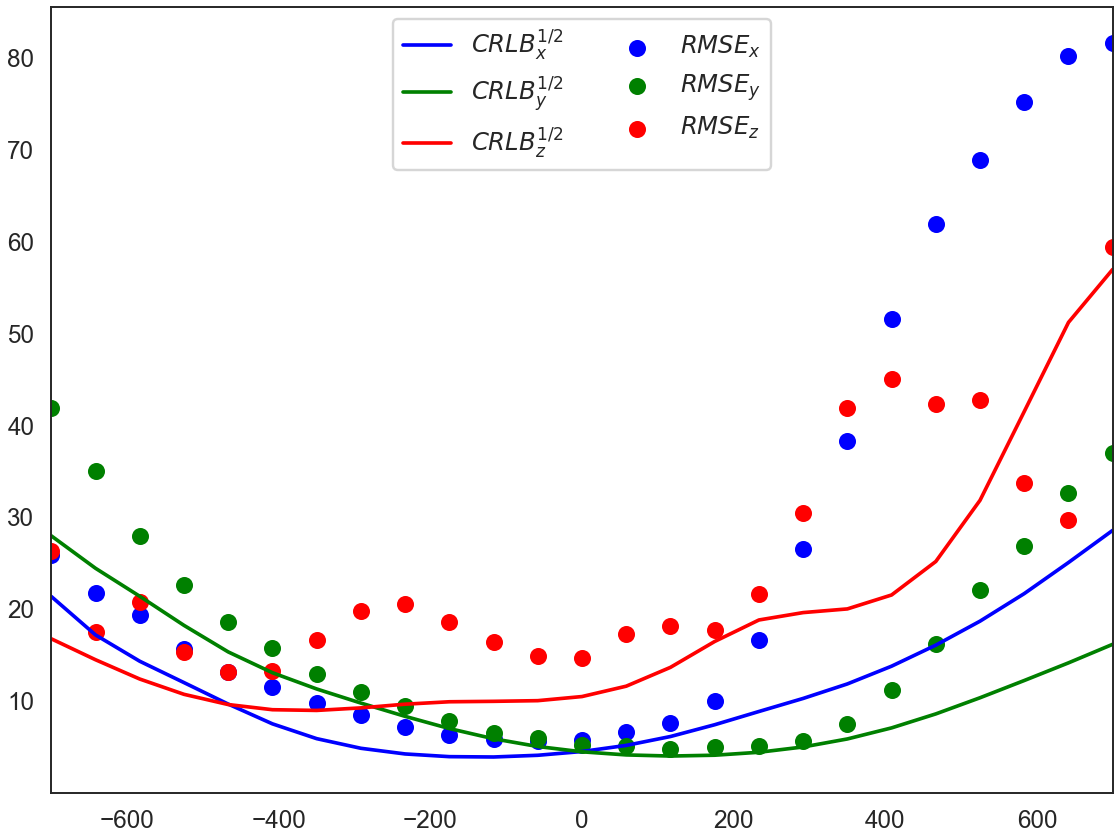

<IPython.core.display.Javascript object>


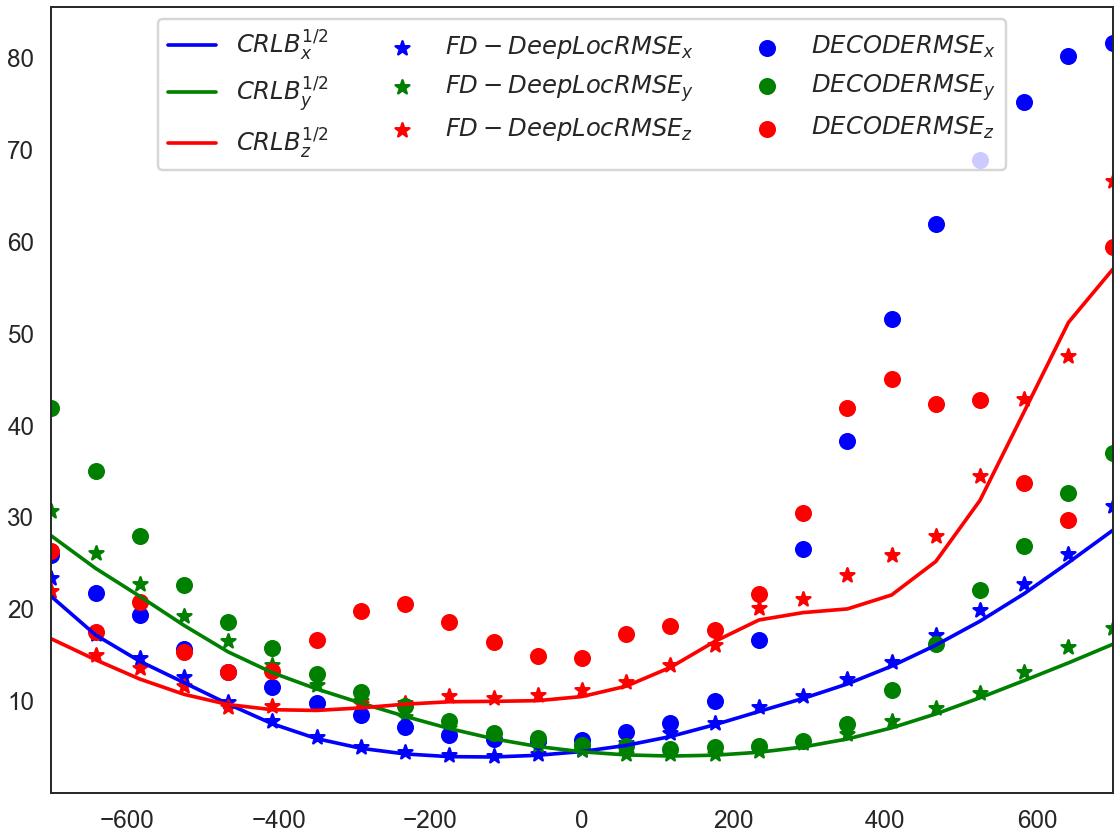

In [6]:
print('------------------------------------------FD-DeepLoc model-------------------------------------------')
zpos, x_crlb, y_crlb, z_crlb, rmse_xyz_fd_deeploc = test_local_CRLB(model=fd_deeploc_model, test_pos=test_pos_list[0], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol,
                use_train_cam=True, test_num=test_num, show_res=True)
print('------------------------------------------DECODE model-------------------------------------------')
zpos, x_crlb, y_crlb, z_crlb, rmse_xyz_decode = test_local_CRLB(model=decode_model, test_pos=test_pos_list[0], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol,
                use_train_cam=True, test_num=test_num, show_res=True)

# compare directly
plt.figure(constrained_layout=True)
plt.plot(zpos, x_crlb,'b', zpos, y_crlb,'g', zpos, z_crlb,'r')
plt.scatter(zpos, rmse_xyz_fd_deeploc[0, :],c="b",marker="*")
plt.scatter(zpos, rmse_xyz_fd_deeploc[1, :],c="g",marker="*")
plt.scatter(zpos, rmse_xyz_fd_deeploc[2, :],c="r",marker="*")
plt.scatter(zpos, rmse_xyz_decode[0, :],c="b",marker="o")
plt.scatter(zpos, rmse_xyz_decode[1, :],c="g",marker="o")
plt.scatter(zpos, rmse_xyz_decode[2, :],c="r",marker="o")
plt.legend(('$CRLB_x^{1/2}$', '$CRLB_y^{1/2}$', '$CRLB_z^{1/2}$', 
            '$FD-DeepLoc RMSE_x$', '$FD-DeepLoc RMSE_y$', '$FD-DeepLoc RMSE_z$', 
            '$DECODE RMSE_x$', '$DECODE RMSE_y$', '$DECODE RMSE_z$'), ncol=3,
           loc='upper center')
plt.xlim([np.min(zpos), np.max(zpos)])
plt.show()

------------------------------------------FD-DeepLoc model-------------------------------------------
compare with PSF CRLB at this position [1945, 1945]
average 3D CRLB is: 703.589296875
simulating single-emitter images for CRLB test
simulated 50000/50000 images

example single-emitter data for CRLB test


<IPython.core.display.Javascript object>


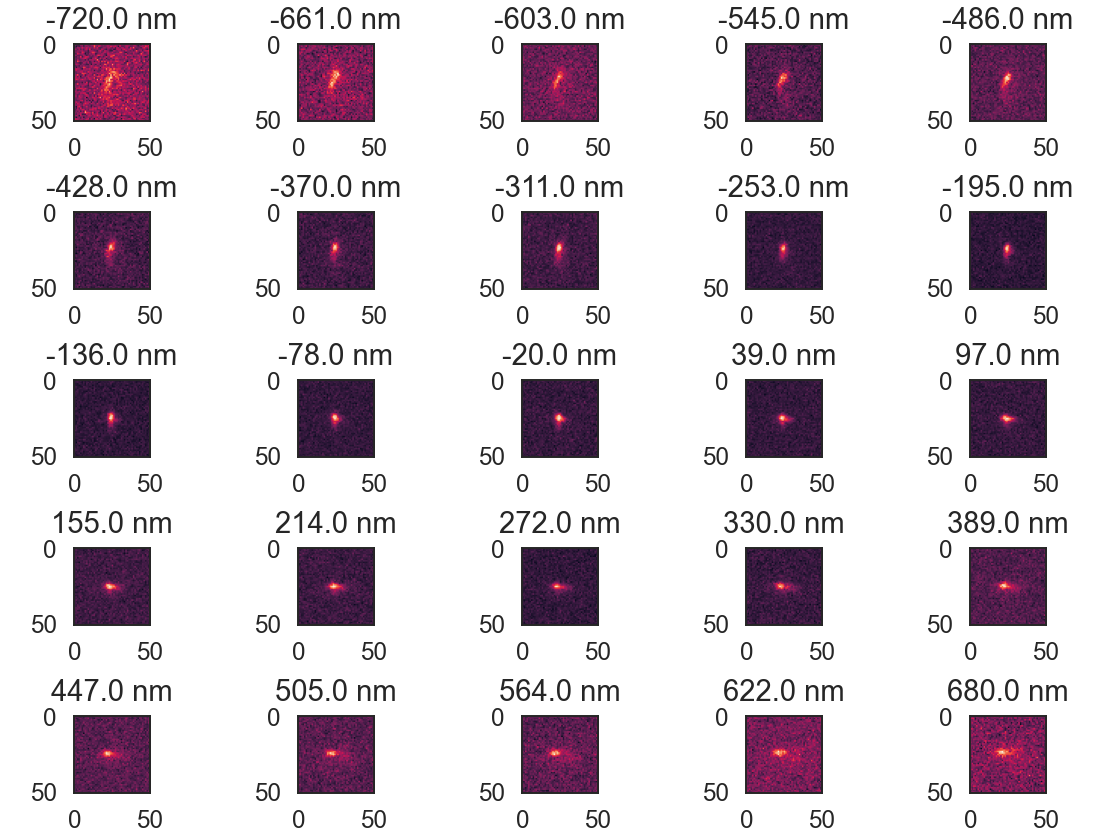

start inferring
field_xy: [1919. 1970. 1919. 1970.] , use_coordconv: True , aber_map_size: (2048, 2048, 23)


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:58<00:00, 105.23it/s]


start computing evaluation metrics

evaluation on 50000 images, contain ground truth: 50000, preds:49394
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 50000 ,preds: 49394
Recall: 0.988
Precision: 1.000
Jaccard: 98.788
RMSE_lat: 20.393
RMSE_ax: 22.762
RMSE_vol: 30.561
Jaccard/RMSE: 4.844
Eff_lat: 79.571
Eff_ax: 88.555
Eff_3d: 84.063
FN: 606.0 FP: 0.0
plot the RMSE of network prediction vs CRLB


<IPython.core.display.Javascript object>


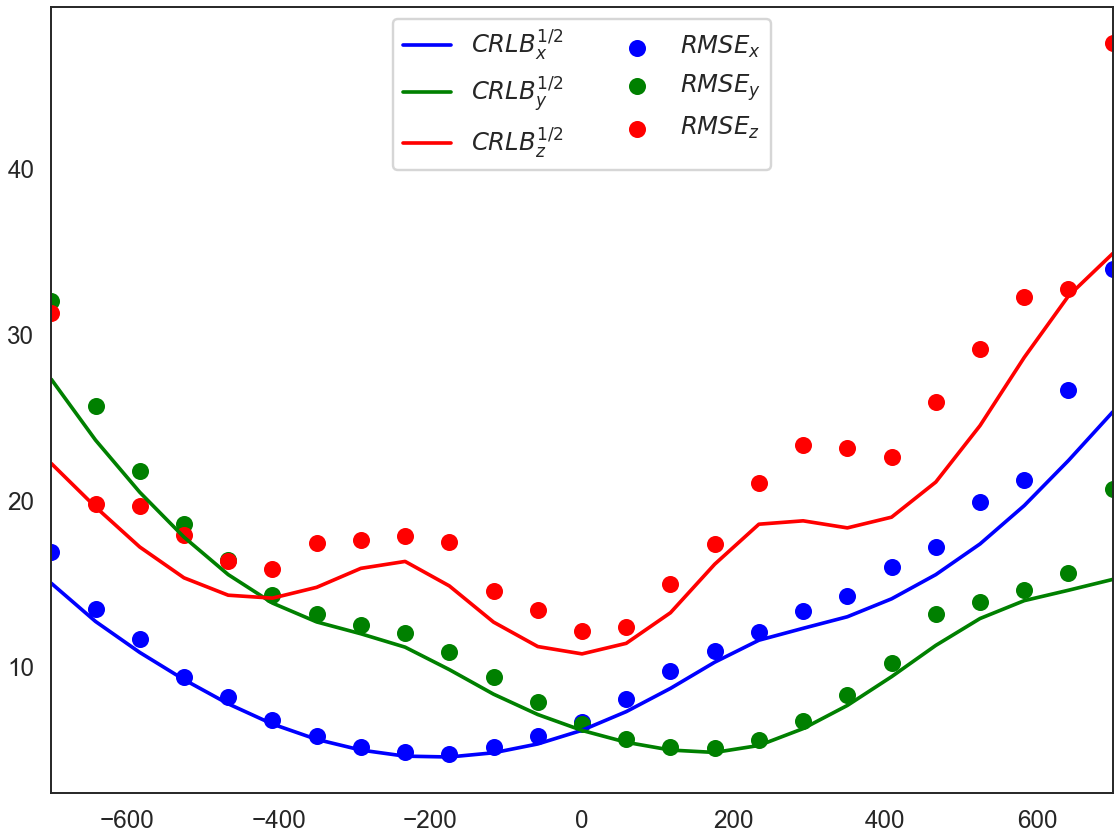

------------------------------------------DECODE model-------------------------------------------
compare with PSF CRLB at this position [1945, 1945]
average 3D CRLB is: 703.589296875
simulating single-emitter images for CRLB test
simulated 50000/50000 images

example single-emitter data for CRLB test


<IPython.core.display.Javascript object>


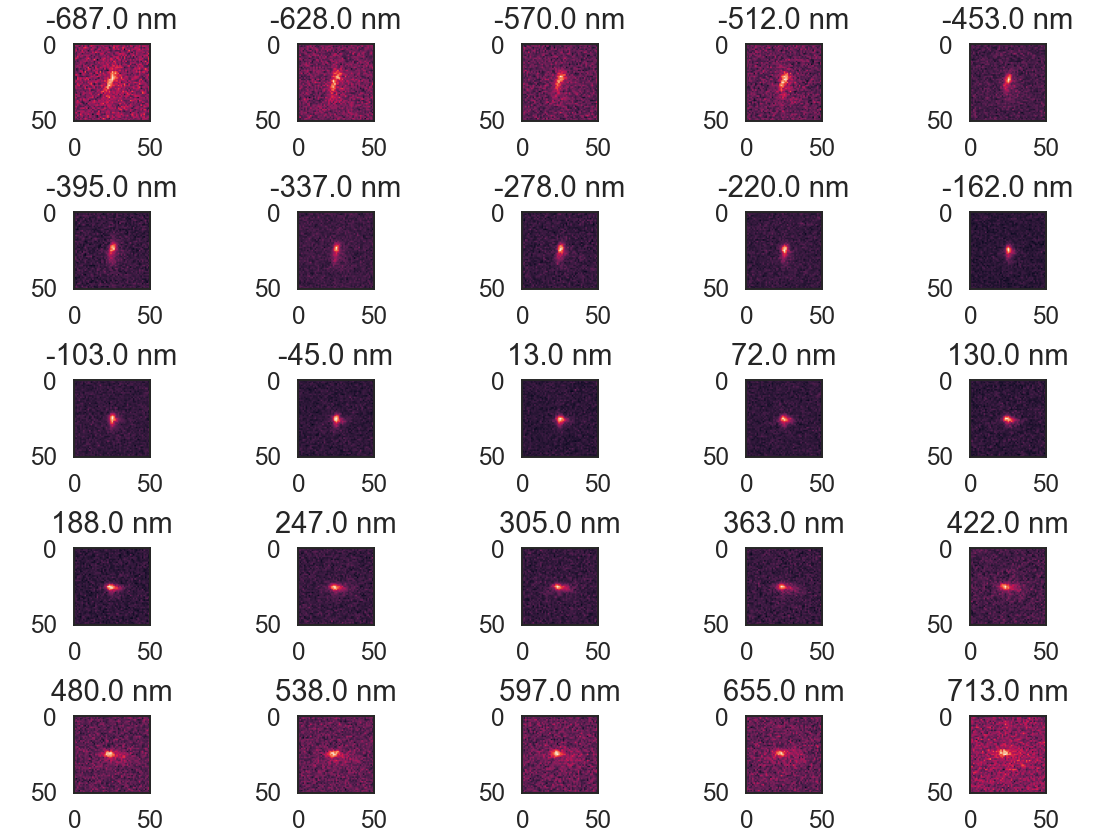

start inferring
field_xy: [1919. 1970. 1919. 1970.] , use_coordconv: False , aber_map_size: (2048, 2048, 23)


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:17<00:00, 160.45it/s]


start computing evaluation metrics

evaluation on 50000 images, contain ground truth: 50000, preds:49982
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 50000 ,preds: 49982
Recall: 0.999
Precision: 0.999
Jaccard: 99.812
RMSE_lat: 39.925
RMSE_ax: 31.734
RMSE_vol: 51.000
Jaccard/RMSE: 2.500
Eff_lat: 60.075
Eff_ax: 84.132
Eff_3d: 72.103
FN: 56.0 FP: 38.0
plot the RMSE of network prediction vs CRLB


<IPython.core.display.Javascript object>


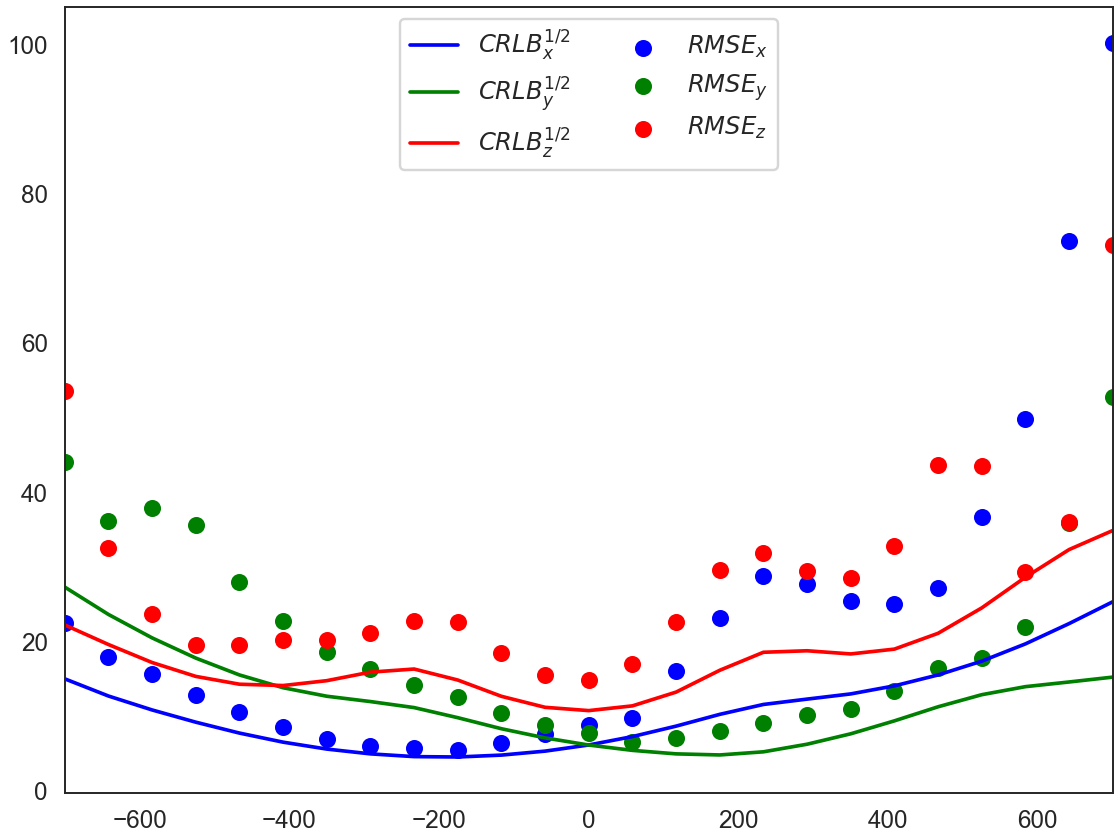

<IPython.core.display.Javascript object>


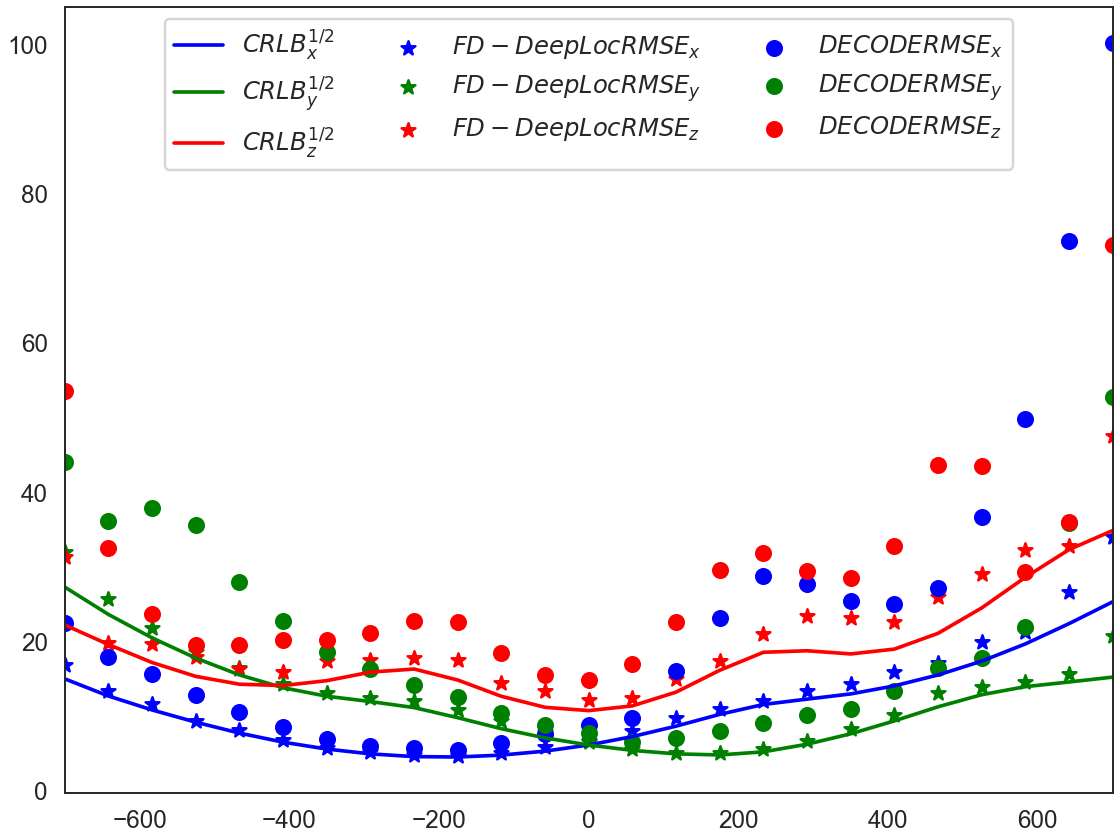

In [7]:
print('------------------------------------------FD-DeepLoc model-------------------------------------------')
zpos, x_crlb, y_crlb, z_crlb, rmse_xyz_fd_deeploc = test_local_CRLB(model=fd_deeploc_model, test_pos=test_pos_list[1], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol,
                use_train_cam=True, test_num=test_num, show_res=True)
print('------------------------------------------DECODE model-------------------------------------------')
zpos, x_crlb, y_crlb, z_crlb, rmse_xyz_decode = test_local_CRLB(model=decode_model, test_pos=test_pos_list[1], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol,
                use_train_cam=True, test_num=test_num, show_res=True)

# compare directly
plt.figure(constrained_layout=True)
plt.plot(zpos, x_crlb,'b', zpos, y_crlb,'g', zpos, z_crlb,'r')
plt.scatter(zpos, rmse_xyz_fd_deeploc[0, :],c="b",marker="*")
plt.scatter(zpos, rmse_xyz_fd_deeploc[1, :],c="g",marker="*")
plt.scatter(zpos, rmse_xyz_fd_deeploc[2, :],c="r",marker="*")
plt.scatter(zpos, rmse_xyz_decode[0, :],c="b",marker="o")
plt.scatter(zpos, rmse_xyz_decode[1, :],c="g",marker="o")
plt.scatter(zpos, rmse_xyz_decode[2, :],c="r",marker="o")
plt.legend(('$CRLB_x^{1/2}$', '$CRLB_y^{1/2}$', '$CRLB_z^{1/2}$', 
            '$FD-DeepLoc RMSE_x$', '$FD-DeepLoc RMSE_y$', '$FD-DeepLoc RMSE_z$', 
            '$DECODE RMSE_x$', '$DECODE RMSE_y$', '$DECODE RMSE_z$'), ncol=3,
           loc='upper center')
plt.xlim([np.min(zpos), np.max(zpos)])
plt.show()

## 6. Start inferring on dataset
* `stack_giga` is the size of sequentially processed images (in gigabyte), it is only an approximate value, set it small when you have limited RAM.
* `pixel_size` is the physical size of each camera pixel (_xy_ in nm).
* `start_field_pos`: **Important**, it is the **_xy_** position of the upper left pixel of the input images in the entire FOV. For example, `start_field_pos` [102,41] means the upper left pixel (namely local position [0,0]) of the input images is located at [102,41] of the whole FOV. Thus CoordConv can get the global position of the input images.

Read big tiff and predict, save the predictions every finish processing `stack_giga`-sized SMLM images, even some accidents happen you will not lose all results. If there is already a prediction file with the same name as `save_path`, inference will start from the last saved frame number in the `save_path` file. We recommend using SMAP to postprocess the prediction list (drift correction, grouping, etc.) and render the super-resolution image (Ries, J. SMAP: a modular super-resolution microscopy analysis platform for SMLM data. Nat Methods 17, 870–872 (2020). https://doi.org/10.1038/s41592-020-0938-1). 
* The parameters haven been explained before.

In [11]:
# set the size of file to be processed sequentially, unit: gigabyte
stack_giga = 0.5
pixel_size = [100, 100]
start_field_pos = [0, 0]

print('------------------------------------------FD-DeepLoc model-------------------------------------------')
# read big tiff and predict, save the predictions every finish processing stack_giga-sized SMLM images,
# even some accidents happen you will not lose all results
total_shape,fov_size = read_bigtiff_and_predict(fd_deeploc_model, image_path, stack_giga=stack_giga, batch_size=10,
                                                use_tqdm=True, nms=True, candi_thre=0.3, nms_thre=0.3,
                                                rescale_xy=False, pixel_size=pixel_size, start_field_pos=start_field_pos, 
                                                divide_and_conquer=True, win_size=256, padding=True, save_path=fd_deeploc_save_path)

print('------------------------------------------DECODE model-------------------------------------------')
total_shape,fov_size = read_bigtiff_and_predict(decode_model, image_path, stack_giga=stack_giga, batch_size=10,
                                                use_tqdm=True, nms=True, candi_thre=0.3, nms_thre=0.3,
                                                rescale_xy=False, pixel_size=pixel_size, start_field_pos=start_field_pos, 
                                                divide_and_conquer=True, win_size=256, padding=True, save_path=decode_save_path)

------------------------------------------FD-DeepLoc model-------------------------------------------
the file to save the predictions is:  ./demo1_FD-DeepLoc_sim_data_normal_aberration_medium_SNR.csv
stack: 1/33, contain imgs: 62, already analyzed:0/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.78it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.14it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.25it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.23it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.39it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.21it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 12.06it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.38it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.14it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.32it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.12it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.29it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.32it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.12it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.29it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.12it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.74it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.16it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.84it/s]



stack: 2/33, contain imgs: 62, already analyzed:62/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.71it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.12it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.84it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.16it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.32it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.14it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.29it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.64it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.66it/s]



stack: 3/33, contain imgs: 62, already analyzed:124/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.69it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.78it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.70it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.74it/s]



stack: 4/33, contain imgs: 62, already analyzed:186/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.45it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.76it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.60it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.66it/s]



stack: 5/33, contain imgs: 62, already analyzed:248/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.12it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.76it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.82it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.64it/s]



stack: 6/33, contain imgs: 62, already analyzed:310/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.71it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.66it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.62it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



stack: 7/33, contain imgs: 62, already analyzed:372/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.68it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.62it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.87it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.07it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.74it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.77it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.47it/s]



stack: 8/33, contain imgs: 62, already analyzed:434/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.61it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.54it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.68it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



stack: 9/33, contain imgs: 62, already analyzed:496/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.96it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.64it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.05it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.49it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



stack: 10/33, contain imgs: 62, already analyzed:558/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.81it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.76it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.29it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.66it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.78it/s]



stack: 11/33, contain imgs: 62, already analyzed:620/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.62it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.94it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.68it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



stack: 12/33, contain imgs: 62, already analyzed:682/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.94it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.62it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.49it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.64it/s]



stack: 13/33, contain imgs: 62, already analyzed:744/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.84it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.94it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.47it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.82it/s]



stack: 14/33, contain imgs: 62, already analyzed:806/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.52it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.60it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.64it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.43it/s]



stack: 15/33, contain imgs: 62, already analyzed:868/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.87it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.74it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.54it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.64it/s]



stack: 16/33, contain imgs: 62, already analyzed:930/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.74it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.82it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.47it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.82it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.43it/s]



stack: 17/33, contain imgs: 62, already analyzed:992/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.01it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.07it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.64it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.94it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.45it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.51it/s]



stack: 18/33, contain imgs: 62, already analyzed:1054/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.99it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.66it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.07it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.64it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.87it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



stack: 19/33, contain imgs: 62, already analyzed:1116/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.82it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.66it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.93it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.43it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.62it/s]



stack: 20/33, contain imgs: 62, already analyzed:1178/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.89it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.07it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.54it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.91it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.53it/s]



stack: 21/33, contain imgs: 62, already analyzed:1240/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.40it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.74it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.45it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.68it/s]



stack: 22/33, contain imgs: 62, already analyzed:1302/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.94it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.82it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.62it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.49it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.58it/s]



stack: 23/33, contain imgs: 62, already analyzed:1364/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.77it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.58it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.91it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.68it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.54it/s]



stack: 24/33, contain imgs: 62, already analyzed:1426/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.17it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.49it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.90it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.94it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.74it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.62it/s]



stack: 25/33, contain imgs: 62, already analyzed:1488/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.93it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.66it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.47it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.60it/s]



stack: 26/33, contain imgs: 62, already analyzed:1550/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.47it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.58it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.93it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.93it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.49it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.18it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.87it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.53it/s]



stack: 27/33, contain imgs: 62, already analyzed:1612/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.65it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.54it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.91it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.82it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.72it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.76it/s]



stack: 28/33, contain imgs: 62, already analyzed:1674/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.70it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.47it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.91it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.94it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.54it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



stack: 29/33, contain imgs: 62, already analyzed:1736/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.88it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.47it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.93it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.05it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.49it/s]



stack: 30/33, contain imgs: 62, already analyzed:1798/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.04it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.74it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.94it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.76it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.57it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.90it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.60it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.54it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.68it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.83it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.49it/s]



stack: 31/33, contain imgs: 62, already analyzed:1860/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.34it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.62it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.94it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.62it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.12it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.54it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.78it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.45it/s]



stack: 32/33, contain imgs: 62, already analyzed:1922/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.69it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.80it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.56it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.94it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.06it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.14it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.67it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.72it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.92it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.86it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.01it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.73it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.07it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.00it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.93it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.85it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.51it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.63it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.65it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.90it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.88it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.62it/s]



stack: 33/33, contain imgs: 16, already analyzed:1984/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.99it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.90it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.46it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.08it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.77it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.72it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.72it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.96it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.27it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.84it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.72it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.93it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.72it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.96it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.27it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.08it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.84it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.90it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.52it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.90it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.90it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.84it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.14it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.55it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.80it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.90it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.84it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.90it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.72it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.84it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.90it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.84it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.72it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.96it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.02it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.72it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.78it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.53it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.66it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.87it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.59it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.77it/s]



analysis finished ! the file containing results is: ./demo1_FD-DeepLoc_sim_data_normal_aberration_medium_SNR.csv
------------------------------------------DECODE model-------------------------------------------
the file to save the predictions is:  ./demo1_DECODE_sim_data_normal_aberration_medium_SNR.csv
stack: 1/33, contain imgs: 62, already analyzed:0/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.13it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.65it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.65it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.65it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.65it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.65it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.68it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.55it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.55it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.35it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.43it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



stack: 2/33, contain imgs: 62, already analyzed:62/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.38it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.55it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



stack: 3/33, contain imgs: 62, already analyzed:124/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.98it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.58it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.52it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



stack: 4/33, contain imgs: 62, already analyzed:186/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.45it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.52it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.48it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.51it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.60it/s]



stack: 5/33, contain imgs: 62, already analyzed:248/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.64it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.67it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.51it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.55it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 6/33, contain imgs: 62, already analyzed:310/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.17it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.66it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.75it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.48it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.50it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.48it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.50it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.55it/s]



stack: 7/33, contain imgs: 62, already analyzed:372/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.92it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.62it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.57it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.47it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.62it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.48it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.45it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.44it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.36it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.52it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.49it/s]



stack: 8/33, contain imgs: 62, already analyzed:434/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.59it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 9/33, contain imgs: 62, already analyzed:496/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.92it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.55it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.67it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.43it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.54it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.55it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.51it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.45it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 10/33, contain imgs: 62, already analyzed:558/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.97it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.62it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.57it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.46it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.51it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 11/33, contain imgs: 62, already analyzed:620/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.73it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.49it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.36it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.44it/s]



stack: 12/33, contain imgs: 62, already analyzed:682/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.28it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.67it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.58it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.57it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.54it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.51it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 13/33, contain imgs: 62, already analyzed:744/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.23it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.51it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.52it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.49it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 14/33, contain imgs: 62, already analyzed:806/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.54it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.69it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.42it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.49it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.50it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 15/33, contain imgs: 62, already analyzed:868/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.70it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.57it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.66it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.51it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.44it/s]



stack: 16/33, contain imgs: 62, already analyzed:930/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.50it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.67it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.52it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.54it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.52it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.50it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



stack: 17/33, contain imgs: 62, already analyzed:992/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.60it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.70it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.75it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.51it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.45it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.47it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.27it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.54it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.39it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.56it/s]



stack: 18/33, contain imgs: 62, already analyzed:1054/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.54it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.66it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.75it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.43it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.52it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.49it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.36it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.45it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.26it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.57it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 19/33, contain imgs: 62, already analyzed:1116/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.30it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.70it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.48it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.36it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.54it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.55it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.44it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.32it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.52it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.51it/s]



stack: 20/33, contain imgs: 62, already analyzed:1178/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.27it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.54it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.59it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.48it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.52it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.55it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.50it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.52it/s]



stack: 21/33, contain imgs: 62, already analyzed:1240/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.59it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.64it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.58it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.45it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.37it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.51it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.46it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.51it/s]



stack: 22/33, contain imgs: 62, already analyzed:1302/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.19it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.51it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.35it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.43it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.35it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.48it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.55it/s]



stack: 23/33, contain imgs: 62, already analyzed:1364/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.32it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.46it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.36it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.35it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.43it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.61it/s]



stack: 24/33, contain imgs: 62, already analyzed:1426/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.81it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.35it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.36it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.43it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.55it/s]



stack: 25/33, contain imgs: 62, already analyzed:1488/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.47it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.67it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.36it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.46it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.50it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.32it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.51it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.55it/s]



stack: 26/33, contain imgs: 62, already analyzed:1550/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.58it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.75it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.57it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.43it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.52it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 27/33, contain imgs: 62, already analyzed:1612/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.66it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.43it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.51it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.50it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.35it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.39it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.48it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.55it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.45it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.51it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.51it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



stack: 28/33, contain imgs: 62, already analyzed:1674/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.59it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.70it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.62it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.54it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.51it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.55it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.51it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.52it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.51it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.54it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.54it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 29/33, contain imgs: 62, already analyzed:1736/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.25it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.55it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.57it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.52it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.46it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



stack: 30/33, contain imgs: 62, already analyzed:1798/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.41it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.52it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.54it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.54it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



stack: 31/33, contain imgs: 62, already analyzed:1860/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.66it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.51it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.59it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.59it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.54it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.38it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.67it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.46it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



stack: 32/33, contain imgs: 62, already analyzed:1922/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.25it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.61it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.71it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.61it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.49it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.46it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.44it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.49it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.47it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.56it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.53it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.50it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.53it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.59it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.60it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.49it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.42it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.63it/s]



stack: 33/33, contain imgs: 16, already analyzed:1984/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.57it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.57it/s]


processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]


processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.90it/s]


processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]


processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]


processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]


processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.91it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]


processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.31it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]


processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]


processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.91it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.78it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]


processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]


processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]


processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.42it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]


processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.86it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.66it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]


processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.67it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.07it/s]


processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.85it/s]


processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.99it/s]


processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.00it/s]


processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.23it/s]

analysis finished ! the file containing results is: ./demo1_DECODE_sim_data_normal_aberration_medium_SNR.csv


## 7. Load the ground-truth and assess.
If in simulation case, we can compare the network's predictions with the ground truth and calculate performance metrics.

In [12]:
eval_csv = read_csv("./demo_datasets/demo1_FD_astig_simu_comparison_and_CRLBtest/ground_truth.csv")

print('------------------------------------------FD-DeepLoc model-------------------------------------------')
# if in simulation, read the predictions and ground truth, then evaluate
fd_deeploc_preds = read_csv(fd_deeploc_save_path).tolist()
# compare the raw predictions and the ground truth
match_dict_raw, matches_raw = assess(test_frame_nbr=total_shape[0], test_csv=eval_csv, pred_inp=fd_deeploc_preds,
                                     size_xy=fov_size, tolerance=250, border=450,
                                     print_res=True, min_int=False, tolerance_ax=500, segmented=False)

print('------------------------------------------DECODE model-------------------------------------------')
decode_preds = read_csv(decode_save_path).tolist()
# compare the raw predictions and the ground truth
match_dict_raw, matches_raw = assess(test_frame_nbr=total_shape[0], test_csv=eval_csv, pred_inp=decode_preds,
                                     size_xy=fov_size, tolerance=250, border=450,
                                     print_res=True, min_int=False, tolerance_ax=500, segmented=False)

------------------------------------------FD-DeepLoc model-------------------------------------------

evaluation on 2000 images, contain ground truth: 908351, preds:890479
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 908274 ,preds: 890434
Recall: 0.980
Precision: 1.000
Jaccard: 97.993
RMSE_lat: 19.649
RMSE_ax: 25.088
RMSE_vol: 31.867
Jaccard/RMSE: 4.987
Eff_lat: 80.248
Eff_ax: 87.296
Eff_3d: 83.772
FN: 18035.0 FP: 195.0
------------------------------------------DECODE model-------------------------------------------

evaluation on 2000 images, contain ground truth: 908351, preds:904789
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 908274 ,preds: 904741
Recall: 0.993
Precision: 0.996
Jaccard: 98.913
RMSE_lat: 39.309
RMSE_ax: 38.629
RMSE_vol: 55.113
Jaccard/RMSE: 2.516
Eff_lat: 60.676
Eff_ax: 80.655
Eff_3d: 70.665
FN: 6720.0 FP: 3187.0


F:\users\FS\FD_DeepLoc_refac\local_utils\plot_funcs.py:98: RuntimeWarning: invalid value encountered in divide
  zavg = zsum / density


------------------------------------------compare the reconstructed image-------------------------------------------


<IPython.core.display.Javascript object>


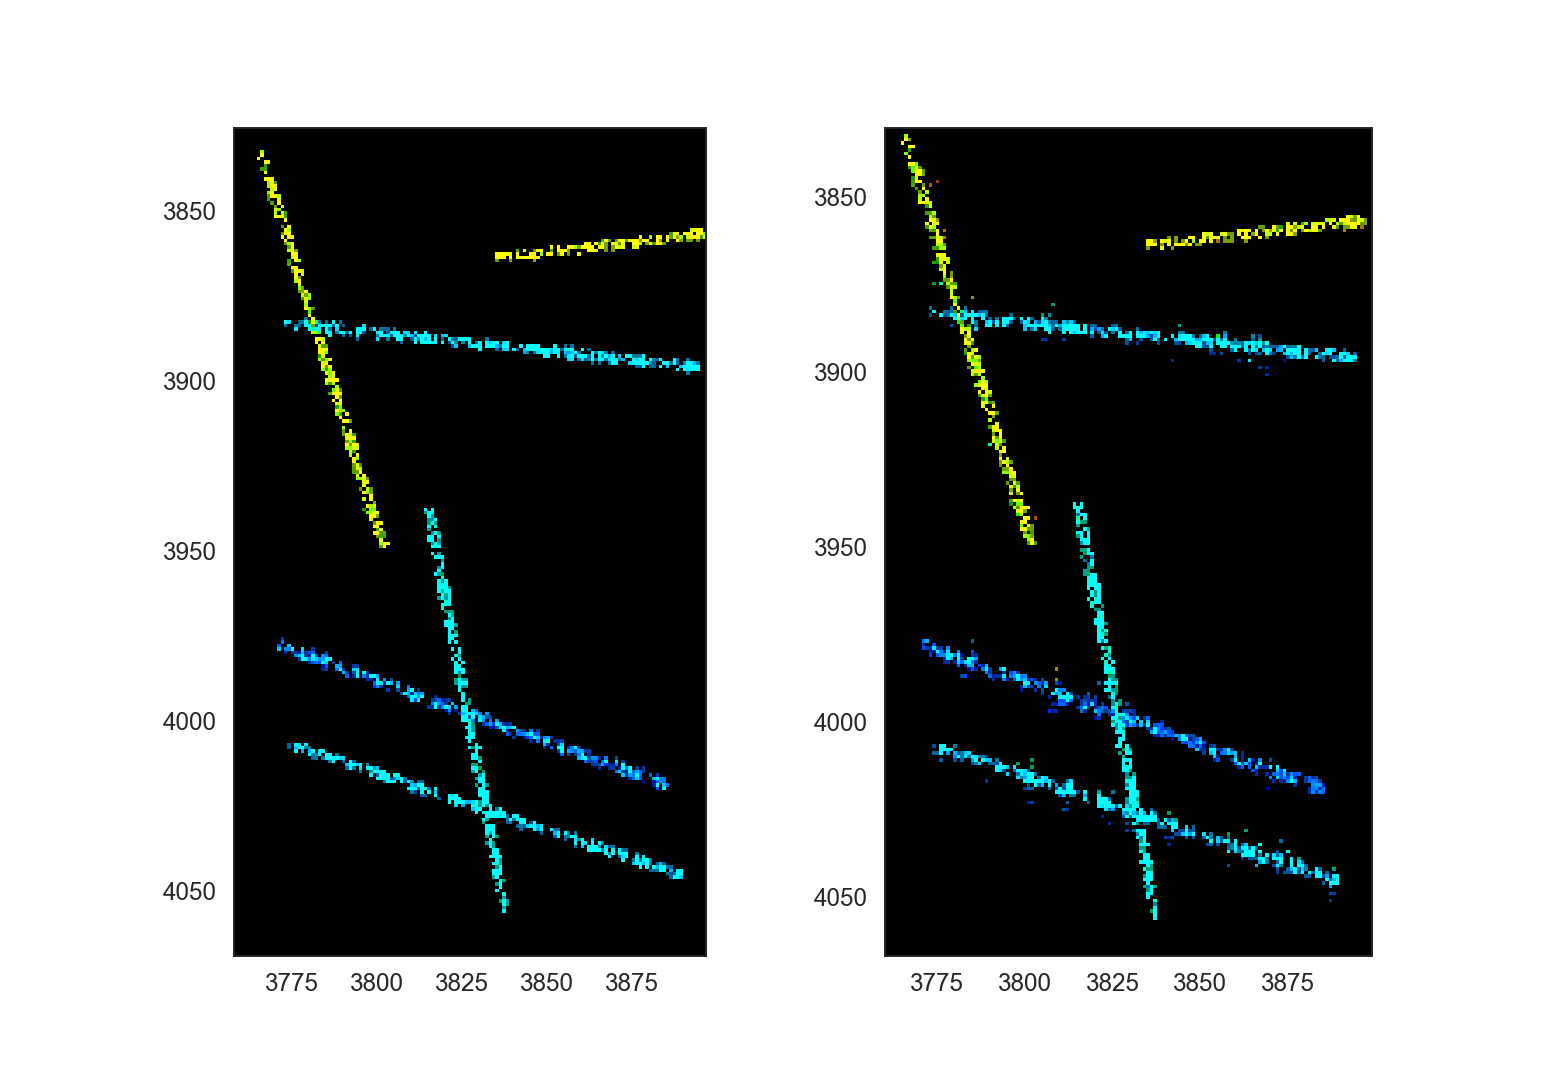

In [13]:
# We recommend using SMAP to postprocess the prediction list (drift correction, grouping, etc.) 
# and render the super-resolution image 
hist_img_fd_deeploc = create_3d_hist(fd_deeploc_preds, z_clip=[-700, 700], pix_size=50, sigma=5, contrast_fac=20)

hist_img_decode = create_3d_hist(decode_preds, z_clip=[-700, 700], pix_size=50, sigma=5, contrast_fac=20)

print('------------------------------------------compare the reconstructed image-------------------------------------------')
plt.figure()
plt.subplot(1,2,1)
plt.imshow(hist_img_fd_deeploc)
plt.subplot(1,2,2)
plt.imshow(hist_img_decode)